# Evaluation of DenseNet-121 and EfficientNet-B0 on Plant Village data

The primary goal of this notebook is to evaluate the performance of DenseNet-121 and EfficientNet-B0 on the PlantVillage dataset. We will compare two distinct transfer learning strategies — Feature Extraction (Head-Only) and Fine-Tuning — to determine which approach yields the best balance of accuracy and generalization.

## Setup

In [69]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sb, dataframe_image as dfi
from typing import Union, List, Optional

Load data from CSV files that were collected during training.

In [16]:
# for DenseNet-121
data_path = f'data_evaluation/densenet121/densenet121'
densenet_finetuned = pd.read_csv(f'{data_path}_finetune_history.csv', index_col='epoch')
densenet_head = pd.read_csv(f'{data_path}_head_history.csv',index_col='epoch')

# for EfficientNet-B0
data_path = f'data_evaluation/efficientnet_b0/efficientnet_b0'
efficientnet_finetuned = pd.read_csv(f'{data_path}_finetune_history.csv',index_col='epoch')
efficientnet_head = pd.read_csv(f'{data_path}_head_history.csv',index_col='epoch')

efficientnet_head[:5]

,train_loss,train_acc,val_loss,val_acc,lr
epoch,,,,,
1,0.726498,0.845065,0.246520,0.941350,0.001
2,0.289336,0.924017,0.178924,0.953043,0.001
3,0.234661,0.934329,0.154008,0.956450,0.001
4,0.208548,0.939669,0.133601,0.961882,0.001
5,0.192616,0.944365,0.133952,0.959580,0.001


## Loss Curves Analysis

We evaluate the performance of DenseNet-121 and EfficientNet-B0 by analyzing their training and validation loss curves. This analysis compares how each model adapts under different transfer learning strategies and highlights the generalization gap (the divergence between training and validation performance) to detect overfitting.

Two training strategies were employed:
> **Head-Only Training (Feature Extraction)**
<br>This strategy freezes the pre-trained "backbone" (which retains generic patterns like shapes and textures from ImageNet). Only the final classification layer (the "head") is trainable, allowing the model to map existing features to our specific classes without altering the underlying feature extractor.

> **Fine-Tuning Training (Last Block)**
<br>This approach unfreezes the final layers of the backbone while keeping early layers frozen. This allows the model to refine its high-level feature representations specifically for our plant dataset, rather than relying solely on the generalized features learned from ImageNet.

Define a custom utility function that standardizes our visualization process. It allows us to dynamically plot single or multiple model histories (like DenseNet vs. EfficientNet) onto specific subplots.

In [17]:
def plot_training_analytics(df:Union[pd.DataFrame, List[pd.DataFrame]], ax:plt.Axes, *metrics:str, title:str='', axis_labels:Optional[List[str]]=None, labels:Optional[List[str]]=None):
    """
    Args:
        df: single DataFrame or a list of DataFrames
        ax: matplotlib axis
        *metrics: column names to plot
        title: main title for the subplot
        axis_labels: [x_label, y_label]
        labels: custom legend labels
    Returns:
        None
    """
    for metric in metrics:
        for i, df in enumerate(df if type(df)==list else [df]):
            ax.plot(df.index, df[metric], label=labels[i] if labels else metric, marker='o')
            
            if axis_labels: 
                ax.set_xlabel(axis_labels[0])
                ax.set_ylabel(axis_labels[1])
        
            ax.set_title(title, fontweight='bold', fontsize=10)
            ax.grid(alpha=0.3)
            ax.legend()

To quantify overfitting, we calculate the **generalization gap**: the difference between the validation loss and the training loss.

In [18]:
for df in [densenet_finetuned, densenet_head, efficientnet_finetuned, efficientnet_head]:
    df['gen_gap'] = df['val_loss'] - df['train_loss']

To conduct a comparative analysis of training performance, we will generate plots for two models (DenseNet-121 and EfficientNet-B0) across two distinct training strategies. Particularly, we will visualize the loss curves and generalization gaps (to detect overfitting).

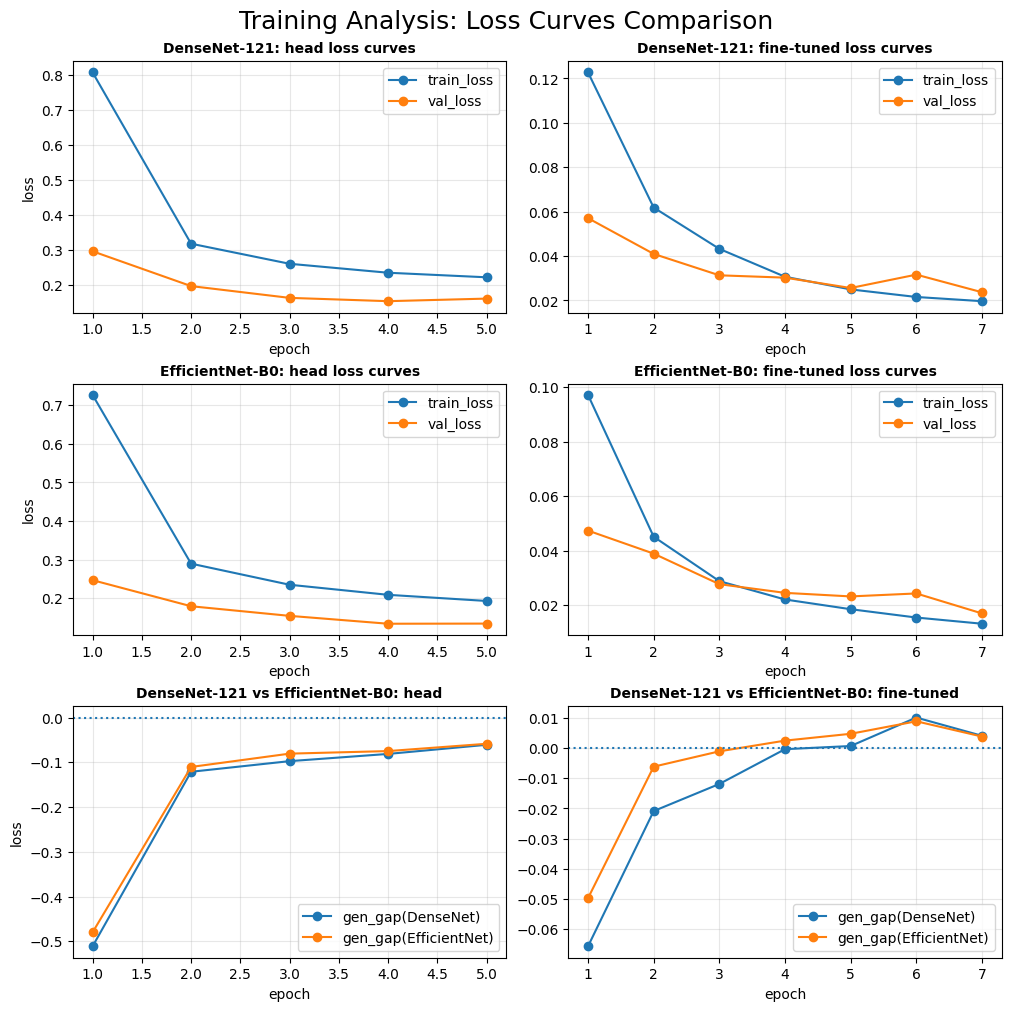

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10), layout="constrained") # add parameter 'layout="constrained"' to automatically adjusts subplots -> not to have overlaps
fig.suptitle("Training Analysis: Loss Curves Comparison", fontsize=18)

'''head-only strategy'''
# densenet
plot_training_analytics(densenet_head, ax[0,0], 'train_loss', 'val_loss', title='DenseNet-121: head loss curves', axis_labels=['epoch','loss'])
# efficientnet
plot_training_analytics(efficientnet_head, ax[1,0],'train_loss','val_loss', title='EfficientNet-B0: head loss curves', axis_labels=['epoch','loss'])

'''fine-tuned strategy'''
# densenet
plot_training_analytics(densenet_finetuned, ax[0,1], 'train_loss', 'val_loss', title='DenseNet-121: fine-tuned loss curves',  axis_labels=['epoch',''])
# efficientnet
plot_training_analytics(efficientnet_finetuned, ax[1,1],'train_loss','val_loss', title='EfficientNet-B0: fine-tuned loss curves', axis_labels=['epoch',''])

'''generalisation gap'''
# densenet
plot_training_analytics([densenet_head, efficientnet_head], ax[2,0], 'gen_gap', title='DenseNet-121 vs EfficientNet-B0: head', labels=['gen_gap(DenseNet)','gen_gap(EfficientNet)'], axis_labels=['epoch','loss'])
ax[2,0].axhline(y=0,linestyle=':') # plot line y=0
# efficientnet
plot_training_analytics([densenet_finetuned, efficientnet_finetuned], ax[2,1], 'gen_gap', title='DenseNet-121 vs EfficientNet-B0: fine-tuned', labels=['gen_gap(DenseNet)','gen_gap(EfficientNet)'], axis_labels=['epoch',''])
ax[2,1].axhline(y=0,linestyle=':') # plot line y=0

plt.show()

> **Head-Only strategy :** model converges quickly but plateaus at a relatively high loss (0.15–0.25). By freezing the backbone, the model is restricted to generic ImageNet features (e.g., basic edges) rather than adapting to specific plant disease textures. This stability prevents "breaking" useful weights but creates an accuracy ceiling, as the features are not fully optimized for the target domain (underfitting).<br> 


> **Fine-Tuning strategy :** loss drops significantly lower (0.02–0.04), indicating much higher accuracy. However, a "crossover point" appears around Epoch 4 in the Generalization Gap plot. So unfreezing the deep layers allows the model to adjust its internal filters to recognize domain-specific features (e.g., specific fungal patterns rather than generic leaf shapes).

**Conclusions :** Both models benefit massively from Fine-Tuning, pushing accuracy from ~96% to >99%. However, EfficientNet-B0 is the preferred model, provided that Early Stopping is implemented around Epoch 5 to mitigate the overfitting risk identified in the generalization gap analysis.

## Accuracy Curves Analysis

The objective of this section is to evaluate the learning dynamics of both models. By tracking accuracy over epochs, we aim to correlate convergence speed (how quickly the model learns) with final performance, while monitoring for potential plateaus or instability.

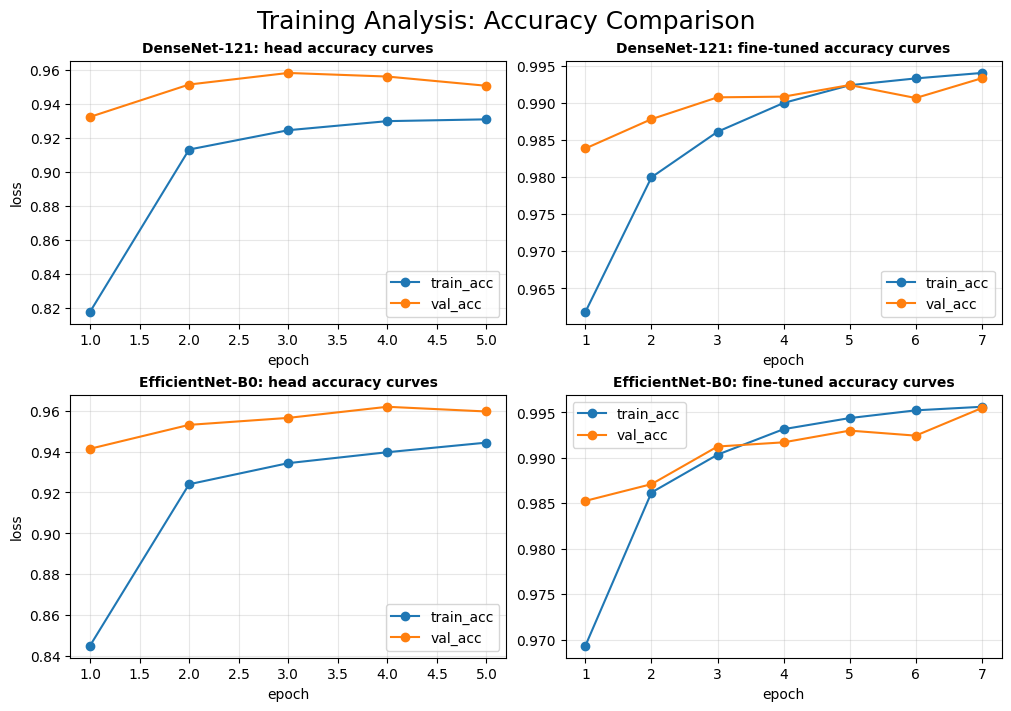

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7), layout="constrained")
fig.suptitle("Training Analysis: Accuracy Comparison", fontsize=18)

'''head-only strategy'''
# desnet
plot_training_analytics(densenet_head, ax[0,0], 'train_acc', 'val_acc', title='DenseNet-121: head accuracy curves', axis_labels=['epoch','loss'])
# efficientnet
plot_training_analytics(efficientnet_head, ax[1,0], 'train_acc', 'val_acc', title='EfficientNet-B0: head accuracy curves', axis_labels=['epoch','loss'])

'''fine-tuned strategy'''
# desnet
plot_training_analytics(densenet_finetuned, ax[0,1],'train_acc', 'val_acc', title='DenseNet-121: fine-tuned accuracy curves', axis_labels=['epoch',''])
# efficientnet
plot_training_analytics(efficientnet_finetuned, ax[1,1], 'train_acc', 'val_acc', title='EfficientNet-B0: fine-tuned accuracy curves', axis_labels=['epoch',''])

> **Head-Only strategy :** models reach a "performance ceiling" relatively quickly (Accuracy ~96%). We can notice that validation loss is lower than training loss. This is typical in transfer learning. The pre-trained weights are already excellent at feature detection, while the training phase likely includes data augmentation or Dropout layers (making training "harder" than validation).


> **Fine-Tuning strategy :** unfreezing the layers unlocks significantly better performance, pushing Accuracy to >99%. The loss values drop by an order of magnitude (from ~0.20 down to ~0.02). This "crossover" indicates that the model has started memorizing the training data (Training Loss < Validation Loss).

**Conclusions :** Both models perform very similarly, but EfficientNet-B0 appears to achieve slightly higher validation accuracy and lower loss in the fine-tuning stage, making it the slightly more efficient candidate for this dataset.

## Global Accuracy Computations

To facilitate a direct performance comparison, we will now aggregate the final accuracy metrics from all model configurations to identify the optimal strategy for deployment.

In [21]:
dfs = {
    "DenseNet-121 (head)": densenet_head,
    "DenseNet-121 (fine-tuned)": densenet_finetuned,
    "EfficientNet-B0 (head)": efficientnet_head,
    "EfficientNet-B0 (fine-tuned)": efficientnet_finetuned
}

Collect data into one DataFrames.

In [54]:
max_acc_df = pd.DataFrame(columns=['model','max_train_acc', 'max_val_acc'])

for i, (name, df) in enumerate(dfs.items()):
    max_train = df['train_acc'].max() * 100
    max_val = df['val_acc'].max() * 100
    max_acc_df.loc[i] = [name, max_train, max_val]

max_acc_df

,model,max_train_acc,max_val_acc
0,DenseNet-121 (head),93.089955,95.819906
1,DenseNet-121 (fine-tuned),99.408434,99.337078
2,EfficientNet-B0 (head),94.436516,96.188196
3,EfficientNet-B0 (fine-tuned),99.562655,99.548844


Restructure data to be in format for seaborn grouped bar plot.

In [55]:
styled_max_acc_df = max_acc_df.melt( 
    id_vars="model", # identifier column that is fixed
    value_vars=["max_train_acc", "max_val_acc"], # columns to stack into rows
    var_name="acc_type", # new name for categorical labels
    value_name="acc" # new name for numerical values
)
styled_max_acc_df

,model,acc_type,acc
0,DenseNet-121 (head),max_train_acc,93.089955
1,DenseNet-121 (fine-tuned),max_train_acc,99.408434
2,EfficientNet-B0 (head),max_train_acc,94.436516
3,EfficientNet-B0 (fine-tuned),max_train_acc,99.562655
4,DenseNet-121 (head),max_val_acc,95.819906
5,DenseNet-121 (fine-tuned),max_val_acc,99.337078
6,EfficientNet-B0 (head),max_val_acc,96.188196
7,EfficientNet-B0 (fine-tuned),max_val_acc,99.548844


Let's plot grouped bar chart to compare the peaks of training accuracy and validation accuracy across all four experimental configurations.

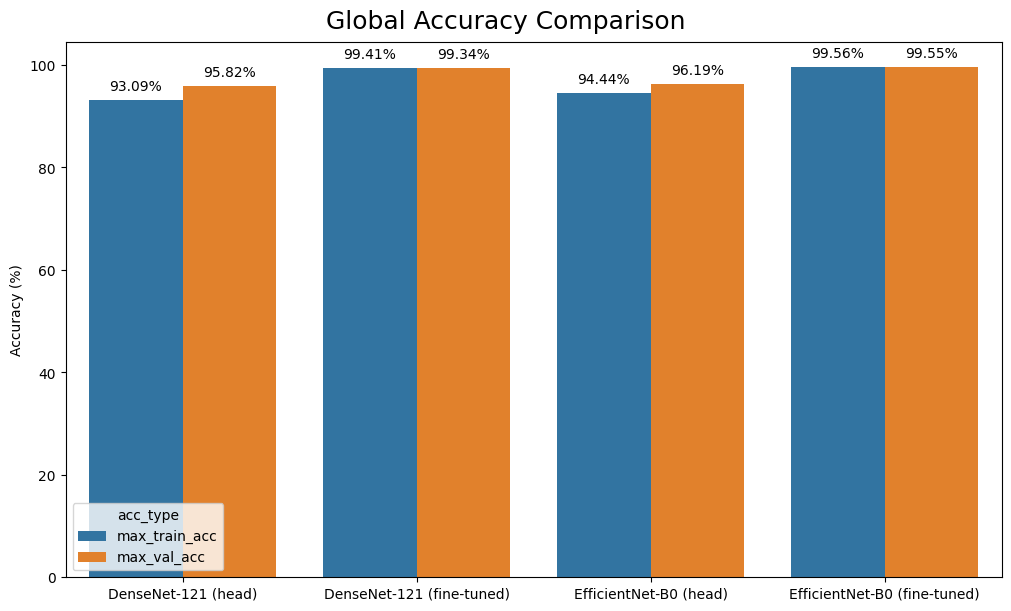

In [49]:
plt.figure(figsize=(10, 6), layout="constrained")
plt.suptitle("Global Accuracy Comparison", fontsize=18)

ax = sb.barplot(data=styled_max_acc_df, x="model", y="acc", hue="acc_type")

for container in ax.containers: # add percentage on top of each bar
    ax.bar_label(container, fmt='%.2f%%', padding=5, fontsize=10) 

plt.ylabel("Accuracy (%)")
plt.xlabel('')
plt.show()

> **Strategy Impact:** Fine-Tuning (right bars) significantly outperforms Head-Only training, boosting validation accuracy from ~96% to over 99% for both architectures. In the "Head-Only" phase, validation accuracy surpasses training accuracy (orange > blue), indicating underfitting. In contrast, the "Fine-Tuned" models show a balanced performance where training and validation scores are nearly identical, demonstrating robust generalization.

**Conclusions :** the top performer is EfficientNet-B0 (Fine-Tuned strategy). It is the most accurate model, achieving a validation accuracy of 99.55%, slightly edging out DenseNet-121 (99.34%).

## Inference

#### Load trained model for inference

In this step, the trained model checkpoint is loaded from disk and restored into the corresponding network architecture. Weights are first loaded on the CPU to avoid unnecessary GPU memory usage, after which the model is moved to the selected device and switched to evaluation mode.


In [ ]:
import torch
import torch.nn as nn

from model import TransferModel
from preprocessing import test_loader, train_dataset
from training import eval_phase

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransferModel(
    num_classes=len(train_dataset.classes),
    backbone="densenet121",
    pretrained=False,
    dropout=0.0
)

state = torch.load("densenet121_best_finetuned.pt", map_location="cpu")
model.load_state_dict(state)
model = model.to(device).eval()

criterion = nn.CrossEntropyLoss()

device: cuda
val_loss=0.0244, val_acc=0.9937


#### Inference on validation data

The loaded model is evaluated on the validation dataset using the same preprocessing pipeline as during training. Validation loss and accuracy are computed without gradient tracking to measure final model performance efficiently.


In [ ]:
with torch.no_grad():
    t_loss, t_acc = eval_phase(model, test_loader, criterion)
print(f"val_loss={t_loss:.4f}, val_acc={t_acc:.4f}")

val_loss=0.0244  val_acc=0.9937


## Summary table

Cleaning and formating existing data to export table summary.

In [61]:
for i, model in enumerate(max_acc_df.model):
    if (model in dfs.keys()):
        # add new column 'learning_rate'
        max_acc_df.at[i, 'learning_rate'] = dfs[model]['lr'].iloc[-1]
        
        # add new column 'epochs'
        max_acc_df.at[i, 'epochs'] = int(len(dfs[model]))
        max_acc_df['epochs'] = max_acc_df['epochs'].fillna(0).astype(int) # to have int value, not float
        
        # add new two columns data related
        max_acc_df['initial_weights'] = 'Imagenet'
        max_acc_df['data'] = 'PlantVillage'

        # split model name and training strategy into separete columns
        model, training_strategy = max_acc_df.loc[i,'model'].split(' ')
        training_strategy = training_strategy.replace('(','').replace(')','')
        
        max_acc_df.at[i, 'model'] = model
        max_acc_df.at[i, 'training_strategy'] = training_strategy

        # round 'max_train_acc', 'max_val_acc' columns
        cols_to_round = ['max_train_acc', 'max_val_acc']
        max_acc_df[cols_to_round] = max_acc_df[cols_to_round].round(2)
    else: 
        print("DataFrame 'max_acc_df' is already updated")
        break

DataFrame 'max_acc_df' is already updated


Refining the DataFrame visualization with custom formatting, column renaming, and metric highlighting for the final export.

In [72]:
cols = {
    'model': 'Model',
    'initial_weights': 'Weights',
    'data': 'Dataset',
    'training_strategy': 'Strategy',
    'learning_rate': 'Learning Rate',
    'max_train_acc': 'Train Acc (%)',
    'max_val_acc': 'Val Acc (%)',
    'epochs': 'Epochs'
}

max_acc_styled_df = max_acc_df.rename(columns=cols).style.format({
        'max_train_acc': '{:.2f}',
        'max_val_acc': '{:.2f}',
        'learning_rate': '{:.4f}'
    }).hide(axis="index")

max_acc_styled_df

Model,Train Acc (%),Val Acc (%),Learning Rate,Epochs,Weights,Dataset,Strategy
DenseNet-121,93.090000,95.820000,0.001000,5,Imagenet,PlantVillage,head
DenseNet-121,99.410000,99.340000,0.000100,7,Imagenet,PlantVillage,fine-tuned
EfficientNet-B0,94.440000,96.190000,0.001000,5,Imagenet,PlantVillage,head
EfficientNet-B0,99.560000,99.550000,0.000100,7,Imagenet,PlantVillage,fine-tuned


Option for exporting table.

In [73]:
dfi.export(max_acc_styled_df, 'project_report/images/model_performance.png', table_conversion='matplotlib')